In [1]:
import os, getpass
from dotenv import load_dotenv, find_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, BaseMessage, AnyMessage
from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from langchain_core.messages import trim_messages, RemoveMessage
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from typing import Annotated, Union
from langgraph.checkpoint.sqlite import SqliteSaver





load_dotenv(find_dotenv())
os.environ["LANGCHAIN_PROJECT"] = "ex_module-2"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
model = ChatGoogleGenerativeAI(model="gemini-1.5-flash",temperature=0)

c:\Users\raulg\Documents\THEBRIDGE_DS\0.-Repo_Git\Material Data Science\Langgraph-course\lc-academy-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Introduction to LangGraph - Module 2 exercises

## Goals:
We're going to test our knowledge after module 2 of Langgraph's course. Concretely:
- Message trimming, filtering and summarization.
- Multiple schemas.
- Storage of the states in an external database.


### 1.- You are given the following list of messages:

In [2]:
messages = [
    {"role": "user", "content": "Hello", "notes": None},
    {"role": "ai", "content": "Good morning, how are you?", "notes": None},
    {"role": "user", "content": "Ok", "notes": "The user says they're ok"},
    {"role": "ai", "content": "Perfect, thank you!", "notes": None},
    {"role": "user", "content": "Can you help me with a problem?", "notes": "User requests assistance"},
    {"role": "ai", "content": "Of course! What can I help you with?", "notes": None},
    {"role": "user", "content": "I'm having trouble with my code", "notes": "User mentions coding issues"},
    {"role": "ai", "content": "I'll be happy to help. Can you describe the problem?", "notes": None},
    {"role": "user", "content": "It's about Python loops", "notes": "User specifies Python loops as the topic"},
    {"role": "ai", "content": "Let's work through your Python loops question together.", "notes": None}
]

Using Langchain's `trim_messages` function, make sure that you only keep the messages that account for **30** tokens. Make it ready to be used in a graph.

In [3]:
trimmed = trim_messages(
        messages,
        max_tokens=30,
        strategy="last",
        token_counter=model,
        allow_partial=False
    )
trimmed

[HumanMessage(content="It's about Python loops", additional_kwargs={'notes': 'User specifies Python loops as the topic'}, response_metadata={}),
 AIMessage(content="Let's work through your Python loops question together.", additional_kwargs={'notes': None}, response_metadata={})]

### 2.- Create a graph that can store the last messages with a total of 30 tokens in an internal list. Show how it works

**Hint**: You'll probably need a custom TypedDict class, since `MessagesState` always adds up new messages instead of replacing them

In [4]:
class custom_messages(TypedDict):
    messages: list[AnyMessage]
    

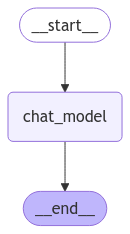

In [5]:
def chat_model_node(state: custom_messages):
    trimmed = trim_messages(
            state["messages"],
            max_tokens=30,
            strategy="last",
            token_counter=model,
            allow_partial=False
        )
    return {"messages": trimmed}

# Build graph
builder = StateGraph(custom_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
chat_model_node({"messages":messages})

{'messages': [HumanMessage(content="It's about Python loops", additional_kwargs={'notes': 'User specifies Python loops as the topic'}, response_metadata={}),
  AIMessage(content="Let's work through your Python loops question together.", additional_kwargs={'notes': None}, response_metadata={})]}

In [7]:
output = graph.invoke({"messages":messages})
for m in output['messages']:
    m.pretty_print()

================================ Human Message =================================

It's about Python loops
================================== Ai Message ==================================

Let's work through your Python loops question together.


#### 2.1.- What if we wanted to filter the messages using MessageState? Can you think on any way to do it? Leave only the messages trimmed by the original node.

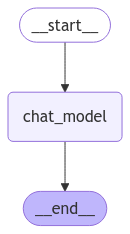

In [16]:
def chat_model_node(state: MessagesState):
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][0:]] ### This is the function that removes **all** the messages
    trimmed = trim_messages(
            state["messages"],
            max_tokens=30,
            strategy="last",
            token_counter=model,
            allow_partial=False
        )
    
    return {"messages": delete_messages + trimmed} ### And we concatenate both the deleted list and the trimmed messages

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
output = graph.invoke({"messages":messages})
for m in output['messages']:
    m.pretty_print()

================================ Human Message =================================

It's about Python loops
================================== Ai Message ==================================

Let's work through your Python loops question together.


### 3.- We now want three-state multiple schema: 
- A state for the model to take as a briefing of the previous conversation (InputState).
- A state that also includes two new keys: the number of the iterarion, and the first node to appear (OverallState).
- A state that only shows a trimmed part of the conversarion, and the first node to appear (OutputState).

#### 3.1.- Create the needed States. 

In [9]:
class InputState(TypedDict): ### We need a custom input state, as it won't work with the normal messagesstate because of naming.
    messages: list[AnyMessage]

class OverallState(TypedDict):
    messages: list[AnyMessage]
    iteration: int
    first_node: str

class OutputState(TypedDict):
    output_messages: list[AnyMessage]
    first_node: str

#### 3.2.- Create a condition that only trims the conversation if there are more than 2 messages

In [10]:
def decide_trimmer(state):
    if len(state['messages']) > 2:
        return "trimmer_node"
    else:
        return "answer_node"

#### 3.3.- Create and compile the new graph, separating a `trimmer_node` and an `answer_node`. Remember to include the `decide_trimmer` and the states created above.

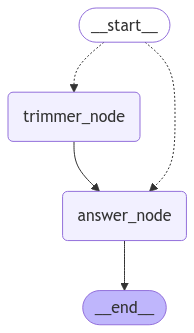

In [11]:
def trimmer_node(state: InputState) -> OverallState:
    trimmed = trim_messages(
            state["messages"],
            max_tokens=30,
            strategy="last",
            token_counter=model,
            allow_partial=False
        )
    return {"messages": trimmed, "iteration": 1, "first_node": "trimmer_node"}

def answer_node(state: InputState | OverallState) -> OutputState: ### This way we make sure either states can be accepted
    messages = state["messages"]
    return {
        "output_messages": model.invoke(messages), 
        "first_node": state.get("first_node", "answer_node")
    }

builder = StateGraph(OverallState, input=InputState, output=OutputState)
builder.add_node("trimmer_node", trimmer_node)
builder.add_node("answer_node", answer_node)
builder.add_conditional_edges(
    START, 
    decide_trimmer,
    {"trimmer_node": "trimmer_node", "answer_node": "answer_node"}
)
builder.add_edge("trimmer_node", "answer_node")
builder.add_edge("answer_node", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
output = graph.invoke({"messages":messages})

In [14]:
output

{'output_messages': AIMessage(content='To best help you, I need more information.  Please tell me:\n\n* **What specifically do you want to know about Python loops?**  Are you having trouble with a particular type of loop (e.g., `for`, `while`)?  Are you trying to understand a specific concept (e.g., loop control statements like `break` and `continue`, nested loops, iterators)?  Are you working on a particular problem and encountering an error?\n\n* **What have you tried already?**  Showing your code (even if it\'s not working) helps me understand your current approach and identify where you might be stuck.\n\n* **What is the desired outcome?**  What should your code be doing?\n\nFor example, you could ask:\n\n* "I\'m trying to use a `for` loop to iterate through a list of numbers and print only the even numbers.  My code isn\'t working correctly.  Here\'s what I have:  `numbers = [1, 2, 3, 4, 5, 6]; for number in numbers: print(number)`  How can I modify it to only print even numbers?"

### 4.- Now we've got some other messages:

In [15]:
messages = [
    {"role": "user", "content": "Hello", "notes": None},
    {"role": "ai", "content": "Good morning, how are you?", "notes": None},
    {"role": "user", "content": "Ok", "notes": "The user says they're ok"},
    {"role": "ai", "content": "Perfect, thank you!", "notes": None},
    {"role": "user", "content": "Can you help me with a problem?", "notes": "User requests assistance"},
    {"role": "ai", "content": "Of course! What can I help you with?", "notes": None},
    {"role": "user", "content": "I'm having trouble with my code", "notes": "User mentions coding issues"},
    {"role": "ai", "content": "I'll be happy to help. Can you describe the problem?", "notes": None},
    {"role": "user", "content": "It's about Python loops", "notes": "User specifies Python loops as the topic"},
    {"role": "ai", "content": "Let's work through your Python loops question together.", "notes": None},
    {"role": "user", "content": "How do I apply the same operation to each item in the collection without writing it out repeatedly?", "notes":"User is asking about the concept of iteration or looping in programming." }
]

Make a function that summarizes all the notes from the user. Include the message trimming used before.

In [16]:
def summarize(state: InputState) -> OverallState:
    summary = state.get("summary", "")
    messages = state["messages"]
    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = f"Create a summary of the conversation above:{messages}"
    
    # Add prompt to our history
    response = model.invoke(summary_message)
    
    # Delete all but the 2 most recent messages
    trimmed_messages = trim_messages(
                        messages,
                        max_tokens=30,
                        strategy="last",
                        token_counter=model,
                        allow_partial=False
                        )   
    return {"summary": response.content, "messages": trimmed_messages, "iteration":1, "first_node":"summarizer"}

### 5.- And build a new graph that includes the summarization as a node. The graph would only use the summarization node whenever there are more than 3 messages, and should also include the trimming of the messages. Make the necessary changes to the states to include the new "summary"


Include the summary on the output so we can see it works

In [18]:
class InputState(TypedDict): ### We need a custom input state, as it won't work with the normal messagesstate because of naming.
    messages: list[AnyMessage]

class OverallState(TypedDict):
    messages: list[AnyMessage]
    summary: str
    iteration: int
    first_node: str

class OutputState(TypedDict):
    output_messages: list[AnyMessage]
    first_node: str
    summary: str

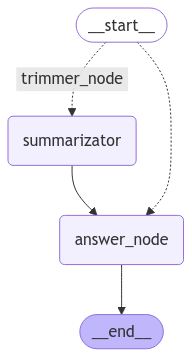

In [19]:
builder = StateGraph(OverallState, input=InputState, output=OutputState)
builder.add_node("summarizator", summarize)
builder.add_node("answer_node", answer_node)
builder.add_conditional_edges(
    START, 
    decide_trimmer,
    {"trimmer_node": "summarizator", "answer_node": "answer_node"}
)
builder.add_edge("summarizator", "answer_node")
builder.add_edge("answer_node", END)
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
output = graph.invoke({"messages":messages})
output

{'output_messages': AIMessage(content='The best way to apply the same operation to each item in a collection without repeating code depends on the programming language you\'re using.  Here are some common approaches:\n\n**1. Loops (Imperative Approach):**\n\nThis is the most fundamental method.  You iterate through the collection and apply the operation within the loop body.\n\n* **Python:**\n\n```python\nmy_list = [1, 2, 3, 4, 5]\n\n# Using a for loop\nfor i in range(len(my_list)):\n    my_list[i] *= 2  # Double each element\n\n# Using a list comprehension (more concise)\nmy_list = [x * 2 for x in my_list]\n\nprint(my_list)  # Output: [2, 4, 6, 8, 10]\n```\n\n* **JavaScript:**\n\n```javascript\nlet myArray = [1, 2, 3, 4, 5];\n\n// Using a for loop\nfor (let i = 0; i < myArray.length; i++) {\n  myArray[i] *= 2;\n}\n\n// Using map (more functional approach)\nlet doubledArray = myArray.map(x => x * 2);\n\nconsole.log(myArray); // Output: [2, 4, 6, 8, 10]\nconsole.log(doubledArray); // Ou

In [21]:
no_sum_messages = [
    # {"role": "user", "content": "Hello", "notes": None},
    # {"role": "ai", "content": "Good morning, how are you?", "notes": None},
    # {"role": "user", "content": "Ok", "notes": "The user says they're ok"},
    # {"role": "ai", "content": "Perfect, thank you!", "notes": None},
    # {"role": "user", "content": "Can you help me with a problem?", "notes": "User requests assistance"},
    # {"role": "ai", "content": "Of course! What can I help you with?", "notes": None},
    # {"role": "user", "content": "I'm having trouble with my code", "notes": "User mentions coding issues"},
    # {"role": "ai", "content": "I'll be happy to help. Can you describe the problem?", "notes": None},
    # {"role": "user", "content": "It's about Python loops", "notes": "User specifies Python loops as the topic"},
    {"role": "ai", "content": "Let's work through your Python loops question together.", "notes": None},
    {"role": "user", "content": "How do I apply the same operation to each item in the collection without writing it out repeatedly?", "notes":"User is asking about the concept of iteration or looping in programming." }

]

In [22]:
output = graph.invoke({"messages":no_sum_messages})
output

{'output_messages': AIMessage(content="The best way to apply the same operation to each item in a collection without repeating code is to use loops or list comprehensions (for lists and similar iterable objects).  Here's how, with examples:\n\n**1. `for` loop:**\n\nThis is the most fundamental approach.  It iterates through each item in the collection, allowing you to perform your operation on each one.\n\n```python\nmy_list = [1, 2, 3, 4, 5]\n\n# Add 1 to each element\nfor i in range(len(my_list)):\n    my_list[i] += 1\n\nprint(my_list)  # Output: [2, 3, 4, 5, 6]\n\n\n#Another example:  Square each number\nmy_list = [1, 2, 3, 4, 5]\nsquared_list = []\nfor num in my_list:\n    squared_list.append(num**2)\n\nprint(squared_list) # Output: [1, 4, 9, 16, 25]\n\n#More efficient way to do the above using list comprehension (see below)\n```\n\n**2. List Comprehension (for lists):**\n\nList comprehensions provide a concise way to create new lists by applying an operation to each item in an exi

### 6.- Now let's store all the messages in a SQLite database:

#### 6.1.- Create a new .db file and create a new table called "messages". Do it with SQLite3.

In [23]:
import sqlite3
conn = sqlite3.connect("data/ex_module-2.db", check_same_thread=False)
cursor = conn.cursor()


#### 6.2.- Make a ckeckpointer with `SQLiteSaver`, and make the functions to call the model, and summarize the conversation coming from the database.


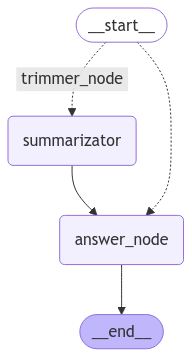

In [25]:
memory = SqliteSaver(conn)

builder = StateGraph(OverallState, input=InputState, output=OutputState)
builder.add_node("summarizator", summarize)
builder.add_node("answer_node", answer_node)
builder.add_conditional_edges(
    START, 
    decide_trimmer,
    {"trimmer_node": "summarizator", "answer_node": "answer_node"}
)
builder.add_edge("summarizator", "answer_node")
builder.add_edge("answer_node", END)
graph = builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

#### 6.3.- Give it a try! Use a thread_id and check that is saved locally. Use the original `messages` list.

In [27]:
config = {"configurable": {"thread_id": "1"}}
graph.invoke({"messages":messages},config)

{'output_messages': AIMessage(content='The best way to apply the same operation to each item in a collection without repeating code depends on the programming language you\'re using.  Here are some common approaches:\n\n**1. Loops (Imperative Approach):**\n\nThis is the most fundamental method.  You iterate through the collection and apply the operation within the loop body.\n\n* **Python:**\n\n```python\nmy_list = [1, 2, 3, 4, 5]\n\n# Using a for loop\nfor i in range(len(my_list)):\n  my_list[i] *= 2  # Double each element\n\n# Using a list comprehension (more concise)\nmy_list = [x * 2 for x in my_list]\n\nprint(my_list)  # Output: [2, 4, 6, 8, 10]\n```\n\n* **JavaScript:**\n\n```javascript\nlet myArray = [1, 2, 3, 4, 5];\n\n// Using a for loop\nfor (let i = 0; i < myArray.length; i++) {\n  myArray[i] *= 2;\n}\n\n// Using map (more functional approach)\nlet doubledArray = myArray.map(x => x * 2);\n\nconsole.log(myArray); // Output: [2, 4, 6, 8, 10]\nconsole.log(doubledArray); // Outp

In [31]:
output = graph.get_state(config)
output

StateSnapshot(values={'messages': [HumanMessage(content='How do I apply the same operation to each item in the collection without writing it out repeatedly?', additional_kwargs={'notes': 'User is asking about the concept of iteration or looping in programming.'}, response_metadata={})], 'summary': "The conversation begins with pleasantries.  The user then requests help with a Python coding problem specifically involving loops.  The user's question focuses on efficiently applying the same operation to every item in a collection, indicating a need for understanding basic iteration techniques in Python.", 'iteration': 1, 'first_node': 'summarizer', 'output_messages': AIMessage(content='The best way to apply the same operation to each item in a collection without repeating code depends on the programming language you\'re using.  Here are some common approaches:\n\n**1. Loops (Imperative Approach):**\n\nThis is the most fundamental method.  You iterate through the collection and apply the o

In [45]:
'''With this example we can see how to turn the summary into a sigle message, thus reducing the necessary input tokens.'''
graph.invoke({'messages':[HumanMessage(content=f"Give an answer given the following summary: {output.values['summary']}")]},config)

{'output_messages': AIMessage(content="Python offers several ways to efficiently apply the same operation to every item in a collection (like a list or tuple).  The most common are `for` loops and list comprehensions.\n\n**Using a `for` loop:**\n\nThis is the most straightforward approach.  You iterate through each item in the collection and perform your operation.\n\n```python\nmy_list = [1, 2, 3, 4, 5]\n\n# Example: Square each number in the list\nsquared_list = []\nfor number in my_list:\n  squared_list.append(number**2)\n\nprint(squared_list)  # Output: [1, 4, 9, 16, 25]\n```\n\n**Using a list comprehension:**\n\nList comprehensions provide a more concise way to achieve the same result.  They are particularly useful for simple operations.\n\n```python\nmy_list = [1, 2, 3, 4, 5]\n\n# Example: Square each number in the list (using list comprehension)\nsquared_list = [number**2 for number in my_list]\n\nprint(squared_list)  # Output: [1, 4, 9, 16, 25]\n```\n\nFor more complex operatio